C:\Users\honglin.wang\PycharmProjects\ML

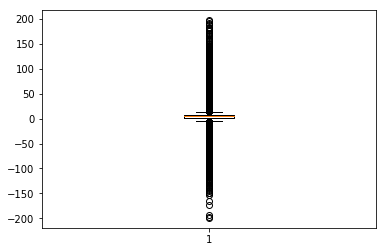

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge
import warnings
warnings.filterwarnings("ignore")

import os
print os.getcwd()

train_data = pd.read_csv("./Earthquake/all/train_1m.csv",dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}, nrows = 1000000)
# print (train_data.head())
# print (train_data.describe())

train_data.to_csv('./Earthquake/all/train_1m.csv')

plt.boxplot(train_data['acoustic_data'])
plt.show()

In [ ]:

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

# Feature Enginering 
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

# print (add_trend_feature([1,-200,3,4,5,100]))

rows = 1000
segments = int(np.floor(train_data.shape[0] / rows))
X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min','q95','q99', 'q05','q01',
                                'abs_max', 'abs_mean', 'abs_std', 'trend', 'abs_trend'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

# print (y_train)
for segment in tqdm(range(segments)):
    seg = train_data.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]

    y_train.loc[segment, 'time_to_failure'] = y

    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'q95'] = np.quantile(x,0.95)
    X_train.loc[segment, 'q99'] = np.quantile(x,0.99)
    X_train.loc[segment, 'q05'] = np.quantile(x,0.05)
    X_train.loc[segment, 'q01'] = np.quantile(x,0.01)

    X_train.loc[segment, 'abs_max'] = np.abs(x).max()
    X_train.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_train.loc[segment, 'abs_std'] = np.abs(x).std()
    X_train.loc[segment, 'trend'] = add_trend_feature(x)
    X_train.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)

# print(X_train.head())
# print (y_train.head())

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
# print (X_train_scaled)

     ave        std    max   min   q95    q99   q05    q01  abs_max  abs_mean    abs_std     trend  abs_trend
0  5.137   4.734789   31.0 -26.0  11.0  21.00  -2.0  -8.01     31.0     5.793   3.904888  0.000020   0.002219
1  5.350   5.915530   31.0 -17.0  15.0  20.01  -4.0  -9.00     31.0     6.428   4.721950 -0.000242  -0.001699
2  5.015  26.686003  104.0 -98.0  53.0  82.03 -44.0 -73.00    104.0    18.147  20.198500 -0.000593   0.033424
3  5.364  17.191902   65.0 -58.0  35.0  53.00 -24.0 -43.00     65.0    13.640  11.759439 -0.000718  -0.018962
4  4.925  10.259112   43.0 -28.0  21.0  31.02 -12.0 -20.00     43.0     9.003   6.960675  0.000658  -0.007192

   time_to_failure
0         1.469099
1         1.469098
2         1.469097
3         1.469096
4         1.468099

In [15]:

submission = pd.read_csv('./Earthquake/all/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)
for seg_id in tqdm(X_test.index):
    seg = pd.read_csv('./Earthquake/all/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
    X_test.loc[seg_id, 'q95'] = np.quantile(x,0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x,0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x,0.05)
    X_test.loc[seg_id, 'q01'] = np.quantile(x,0.01)
    
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x).std()
    X_test.loc[seg_id, 'trend'] = add_trend_feature(x)
    X_test.loc[seg_id, 'abs_trend'] = add_trend_feature(x, abs_values=True)

print (X_test.describe())
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test.columns)


               ave          std          max          min          q95          q99          q05          q01      abs_max     abs_mean      abs_std         trend     abs_trend
count  2624.000000  2624.000000  2624.000000  2624.000000  2624.000000  2624.000000  2624.000000  2624.000000  2624.000000  2624.000000  2624.000000  2.624000e+03  2.624000e+03
mean      4.148616     6.684138   165.683689  -154.099848    10.998857    20.429184    -2.692073   -12.083952   173.052591     5.308058     5.840772 -5.323809e-08 -1.529011e-06
std       0.252326     8.744606   276.517022   291.376009     2.423279    14.711809     2.416047    14.902307   308.452089     1.602270     8.576887  1.831795e-06  3.164217e-05
min       3.410040     2.848331    28.000000 -6323.000000     8.000000    10.000000   -42.000000  -351.010000    28.000000     3.846733     2.487409 -6.547496e-06 -7.218583e-04
25%       3.974123     4.640124    93.000000  -162.000000    10.000000    15.000000    -3.000000   -15.000000    95

In [17]:


import time
import lightgbm as lgb

# start to train model
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "nthread": 4,
         "verbosity": -1}

features = X_train_scaled.columns
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(X_train_scaled))
predictions = np.zeros(len(X_test_scaled))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_scaled.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(X_train_scaled.iloc[trn_idx][features], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train_scaled.iloc[val_idx][features], label=y_train.iloc[val_idx])

    num_round = 100
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(X_train_scaled.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(X_test_scaled[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, y_train)**0.5))
